In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/emails.csv")

### Group by Subject

In [ ]:
import re

def extract_subject(message):
    match = re.search(r'^Subject:\s*(.*)$', message, re.MULTILINE)
    if match:
        return match.group(1).strip()
    return None  

df['subject'] = df['message'].apply(extract_subject)

In [ ]:
# Group emails by subject and calculate the count for each group
grouped_counts = df.groupby('subject').size()
sorted_grouped_counts = grouped_counts.sort_values(ascending=False)
print(sorted_grouped_counts)


subject
Mime-Version: 1.0                                                 17015
RE:                                                                6477
Re:                                                                6308
Demand Ken Lay Donate Proceeds from Enron Stock Sales              1124
FW:                                                                 938
                                                                  ...  
Mtg w/Beldon & Calger (via teleconf) Delainey & Lavorato - RE:        1
Mtg w/Andy Fastow                                                     1
Mtg w/ Power & Gas traders EB3321                                     1
Mtg w/ Laura Schwartz (34535)(Pat Radford)  re CPS                    1
~~~~~~~TOP-NOTCH Attorneys For PENNIES A Day ~~~~~~~                  1
Length: 159550, dtype: int64


In [5]:
grouped_messages = df.groupby('subject')['message'].apply(list)


In [ ]:
subject_to_view = "Congratulations"
if subject_to_view in grouped_messages:
    for i, message in enumerate(grouped_messages[subject_to_view], start=1):
        print(f"Message {i}:\n{message}\n{'-'*40}\n")
else:
    print(f"No messages found with subject: {subject_to_view}")


Message 1:
Message-ID: <1406388.1075840334396.JavaMail.evans@thyme>
Date: Mon, 7 Jan 2002 22:00:02 -0800 (PST)
From: wincash@play4keeps.com
To: don.baughman@enron.com
Subject: Congratulations
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Play4Cash <WinCash@Play4Keeps.com>@ENRON
X-To: Baughman Jr., Don </O=ENRON/OU=NA/CN=RECIPIENTS/CN=DBAUGHM>
X-cc: 
X-bcc: 
X-Folder: \ExMerge - Baughman Jr., Don\Deleted Items
X-Origin: BAUGHMAN-D
X-FileName: don baughman 6-25-02.PST

Congratulations!
We're ready to send your FREE GIFT

Congratulations! You've been chosen to receive the best-selling, Meikai
 35 mm Switchable Panorama Camera - absolutely FREE!

To claim your FREE 35mm Panorama Camera, click the link below

http://www.play4keeps.com/rd.cgi?camera

How can I afford to give away the camera people have paid as much as $65 for?"

Simply put, I can't. At least not to everyone, but you were smart enough to request free products from your-fr

In [ ]:
import re
from dateutil import parser
import numpy as np

def extract_header(message, header):
    """Extract the value of a given header from the email message."""
    pattern = rf'^{header}:\s*(.*)$'
    match = re.search(pattern, message, re.MULTILINE)
    if match:
        return match.group(1).strip()
    return None



In [ ]:
def extract_content(message):
    """Extract the content (body) of an email message."""
    parts = message.split('\n\n', 1)
    if len(parts) > 1:
        return parts[1].strip() 
    return ""

df['content'] = df['message'].apply(extract_content)


In [11]:
extract_header(df['message'][908], 'Date')

'Tue, 12 Dec 2000 04:41:00 -0800 (PST)'

In [9]:
from dateutil import parser
import pytz

def parse_date(date_string):
    """Convert a date string to a datetime object using dateutil.parser."""
    try:
        parsed_date = parser.parse(date_string)
        utc_date = parsed_date.astimezone(pytz.utc)

        return utc_date
    except Exception:
        return pd.NaT

In [10]:
# Assume df is your DataFrame with a column 'message'
# Extract relevant headers and create new columns
df['message_id'] = df['message'].apply(lambda m: extract_header(m, 'Message-ID'))
df['date_str']   = df['message'].apply(lambda m: extract_header(m, 'Date'))
df['stand_date'] = df['date_str'].apply(parse_date)
df['from']       = df['message'].apply(lambda m: extract_header(m, 'From'))
df['to']         = df['message'].apply(lambda m: extract_header(m, 'To'))
df['subject']    = df['message'].apply(lambda m: extract_header(m, 'Subject'))


In [ ]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

df = df.dropna(subset=['stand_date','from','to','subject']).copy()

df['got_reply'] = 0
df['reply_row'] = np.nan

df1 = df[['stand_date','subject','from','to']].copy()
df1['i'] = df.index  # remember original row index
df1['reply_subject'] = "Re: " + df1['subject']

df2 = df[['stand_date','subject','from','to']].copy()
df2['j'] = df.index

df2.rename(columns={'stand_date': 'reply_date',
                    'subject': 'reply_subject',
                    'from': 'reply_from',
                    'to': 'reply_to'}, inplace=True)

merged = df1.merge(
    df2,
    how='left',
    left_on=['reply_subject','from','to'],
    right_on=['reply_subject','reply_to','reply_from']
)

merged = merged[merged['reply_date'] > merged['stand_date']]

merged.sort_values('reply_date', inplace=True)
first_replies = merged.groupby('i')['j'].first()

df.loc[first_replies.index, 'got_reply'] = 1
df.loc[first_replies.index, 'reply_row'] = first_replies.values

print("Processing complete (self-merge approach)!")


## Chained Email

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../data/emails.csv")

In [ ]:
import re
import pandas as pd
from dateutil import parser
import pytz

def parse_date(date_string):
    """Convert a date string to a datetime object using dateutil.parser."""
    try:
        parsed_date = parser.parse(date_string)
        utc_date = parsed_date.astimezone(pytz.utc)
        return utc_date
    except Exception:
        return pd.NaT

def extract_header(message, header_name):
    """Extracts a header value from the raw email message."""
    pattern = re.compile(rf'^{header_name}:\s*(.*)$', re.MULTILINE)
    match = pattern.search(message)
    if match:
        return match.group(1).strip()
    return ""

def extract_email_bodies(message):
    
    parts = message.split("\n\n", 1)
    if len(parts) < 2:
        return message, []  
    
    body = parts[1]
    
    if "-----Original Message-----" in body:
        main_body, chained_part = body.split("-----Original Message-----", 1)
        main_body = main_body.strip()
        chained_emails = [
            "-----Original Message-----" + chunk.strip()
            for chunk in chained_part.split("-----Original Message-----") if chunk.strip()
        ]
    else:
        main_body = body.strip()
        chained_emails = []
    
    return main_body, chained_emails

df['message_id'] = df['message'].apply(lambda m: extract_header(m, 'Message-ID'))
df['date_str']   = df['message'].apply(lambda m: extract_header(m, 'Date'))
df['stand_date'] = df['date_str'].apply(parse_date)
df['from']       = df['message'].apply(lambda m: extract_header(m, 'From'))
df['to']         = df['message'].apply(lambda m: extract_header(m, 'To'))
df['subject']    = df['message'].apply(lambda m: extract_header(m, 'Subject'))

df[['main_body', 'chained_emails']] = df['message'].apply(lambda m: pd.Series(extract_email_bodies(m)))


In [6]:
df.head()

,file,message,message_id,date_str,stand_date,from,to,subject,main_body,chained_emails
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",2001-05-14 23:39:00+00:00,phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,[]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",2001-05-04 20:51:00+00:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,[]
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",2000-10-18 10:00:00+00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,[]
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",2000-10-23 13:13:00+00:00,phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",[]
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",2000-08-31 12:07:00+00:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,[]


In [ ]:
def clean_chained_email(message):
    """
    Cleans a chained email string by removing the marker and any extraneous quoting.
    
    This function does two things:
      1. Removes any '-----Original Message-----' marker (even if it has trailing symbols).
      2. Strips leading quote markers (e.g., '>') from each line.
    """
    message = re.sub(r'^\s*-----Original Message-----\s*>?\s*', '', message, flags=re.MULTILINE)
    message = re.sub(r'^\s*>+\s*', '', message, flags=re.MULTILINE)
    return message.strip()

In [ ]:
df_chained = df[['message_id', 'stand_date', 'chained_emails']].explode('chained_emails')
df_chained['chained_subject'] = df_chained['chained_emails'].apply(
    lambda m: extract_header(clean_chained_email(m), 'Subject') if isinstance(m, str) else ""
)

df_chained['chained_from'] = df_chained['chained_emails'].apply(
    lambda m: extract_header(clean_chained_email(m), 'From') if isinstance(m, str) else ""
)


df_chained['chained_to'] = df_chained['chained_emails'].apply(
    lambda m: extract_header(clean_chained_email(m), 'To') if isinstance(m, str) else ""
)
df_chained['chained_date_str'] = df_chained['chained_emails'].apply(
    lambda m: extract_header(clean_chained_email(m), 'Sent') if isinstance(m, str) else ""
)
df_chained['chained_date'] = df_chained['chained_date_str'].apply(parse_date)
df_chained['chained_main_body'] = df_chained['chained_emails'].apply(
    lambda m: extract_email_bodies(clean_chained_email(m))[0] if isinstance(m, str) else ""
)

/home/gio/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [10]:
df_chained = df_chained.dropna(subset=['chained_emails']).reset_index()

In [ ]:
df_chained

In [11]:
df_chained.head(10)

,index,message_id,stand_date,chained_emails,chained_subject,chained_from,chained_to,chained_date_str,chained_date,chained_main_body
0,66,<17954197.1075855688641.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prompt attenti...
1,66,<17954197.1075855688641.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Phillip K Alle...,John Lavorato-M,Phillip K Allen [mailto:Phillip.K.Allen@enron....,debe@fsddatasvc.com,"Thursday, August 31, 2000 12:03 PM",2000-08-31 17:03:00+00:00,John Lavorato-M\n\nMike Grigsby-D\nKeith Holst...
2,71,<33396487.1075855688749.JavaMail.evans@thyme>,2000-08-31 13:14:00+00:00,-----Original Message-----From: Phillip K Alle...,John Lavorato-M,Phillip K Allen [mailto:Phillip.K.Allen@enron....,debe@fsddatasvc.com,"Thursday, August 31, 2000 12:03 PM",2000-08-31 17:03:00+00:00,John Lavorato-M\n\nMike Grigsby-D\nKeith Holst...
3,247,<2398018.1075855692214.JavaMail.evans@thyme>,2000-02-11 12:31:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...
4,248,<4627792.1075855692236.JavaMail.evans@thyme>,2000-02-09 10:27:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...
5,263,<12222503.1075855692514.JavaMail.evans@thyme>,2000-01-18 18:06:00+00:00,-----Original Message-----From: pallen@enron.c...,Choosing a style,pallen@enron.com [mailto:pallen@enron.com],designadvice@living.com,"Monday, January 17, 2000 5:20 PM",2000-01-17 23:20:00+00:00,I am planning to build a house in the Texas hi...
6,315,<3401311.1075855724513.JavaMail.evans@thyme>,2001-04-18 14:51:00+00:00,"-----Original Message-----From: Allen, Philli...",Re: Presentation to Trading Track A&A,"Allen, Phillip","Buckley, Karen","Wednesday, April 18, 2001 10:30 AM",2001-04-18 15:30:00+00:00,The topic will the the western natural gas mar...
7,341,<30542109.1075855379282.JavaMail.evans@thyme>,2001-04-19 00:51:00+00:00,"-----Original Message-----From: \tAllen, Phill...",Re: Presentation to Trading Track A&A,"Allen, Phillip","Buckley, Karen","Wednesday, April 18, 2001 10:30 AM",2001-04-18 15:30:00+00:00,The topic will the the western natural gas mar...
8,371,<8142619.1075855725654.JavaMail.evans@thyme>,2001-03-19 11:48:00+00:00,-----Original Message-----From: Phillip.K.Alle...,Re: Buyout,Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,llewter@austin.rr.com,"Monday, March 19, 2001 8:45 AM",2001-03-19 14:45:00+00:00,"Larrry,\n\nI realize you are disappointed abou..."
9,405,<4668224.1075855726338.JavaMail.evans@thyme>,2001-03-06 10:45:00+00:00,"-----Original Message-----From: Hayden, Frank...",Cross Commodity,"Hayden, Frank =20","Presto, Kevin; Zufferli, John; McKay, Jonathan...","Friday, March 02, 2001 7:01 PM",2001-03-03 01:01:00+00:00,"I=01,ve been asked to provide an updated list ..."


In [ ]:
def compute_chain_response_time(group):
    """
    For a group of chained emails (all with the same message_id),
    compute a new column 'chain_response_time' where:
      - The first row's response time = original stand_date - first chained_date.
      - For subsequent rows, response time = previous row's chained_date - current row's chained_date.
    """
    orig_date = group['stand_date'].iloc[0]
    response_times = []
    previous_date = orig_date  
    for idx, row in group.iterrows():
        resp_time = previous_date - row['chained_date']
        response_times.append(resp_time)
        previous_date = row['chained_date']
    return pd.Series(response_times, index=group.index)

df_chained['chain_response_time'] = (
    df_chained.groupby('message_id')
              .apply(compute_chain_response_time)
              .reset_index(level=0, drop=True)
)



/tmp/ipykernel_990171/976557368.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_chain_response_time)


In [110]:
len(df_chained)

140762

In [111]:
df_chained = df_chained[df_chained['chain_response_time'] >= pd.Timedelta(0)]
len(df_chained)

114195

In [102]:
df_chained['chained_emails'][4]

'-----Original Message-----> From: Phillip_K_Allen@enron.com [mailto:Phillip_K_Allen@enron.com]\n> Sent: Monday, February 07, 2000 5:54 PM\n> To: george.rahal@acnpower.com\n> Subject: Re: W basis quotes\n>\n>\n>\n> George,\n>\n>      Can you please call my credit desk at 713-853-1803.  They have not\n> received any financials for ACN Power.\n>\n> Thanks,\n>\n> Phillip Allen\n>\n>'

In [103]:
df_chained['chained_main_body'][4]

'From: Phillip_K_Allen@enron.com [mailto:Phillip_K_Allen@enron.com]\nSent: Monday, February 07, 2000 5:54 PM\nTo: george.rahal@acnpower.com\nSubject: Re: W basis quotes\nGeorge,\nCan you please call my credit desk at 713-853-1803.  They have not\nreceived any financials for ACN Power.\nThanks,\nPhillip Allen'

In [108]:
response_data.describe()

count    126808.000000
mean        -37.201667
std        4852.592299
min     -219150.016667
25%           0.105833
50%           1.402778
75%          17.550000
max      210623.733333
Name: response_hours, dtype: float64

### KDE & ECDF
KDE (Kernel Density Estimate):
A KDE is a non-parametric way to estimate the probability density function of a dataset. Instead of assuming a specific distribution (like normal), it "smooths" the data by placing a small, smooth curve (a kernel, often Gaussian) at each data point and summing them. The result is a continuous curve that gives you an idea of where the data points are concentrated.

ECDF (Empirical Cumulative Distribution Function):
An ECDF shows the proportion of data points that are less than or equal to each value in your dataset. It's a step function that increases with each data point. For any value 
x
x, the ECDF tells you what fraction of your data is below 
x
x. This makes it useful for understanding the distribution and for comparing different datasets.

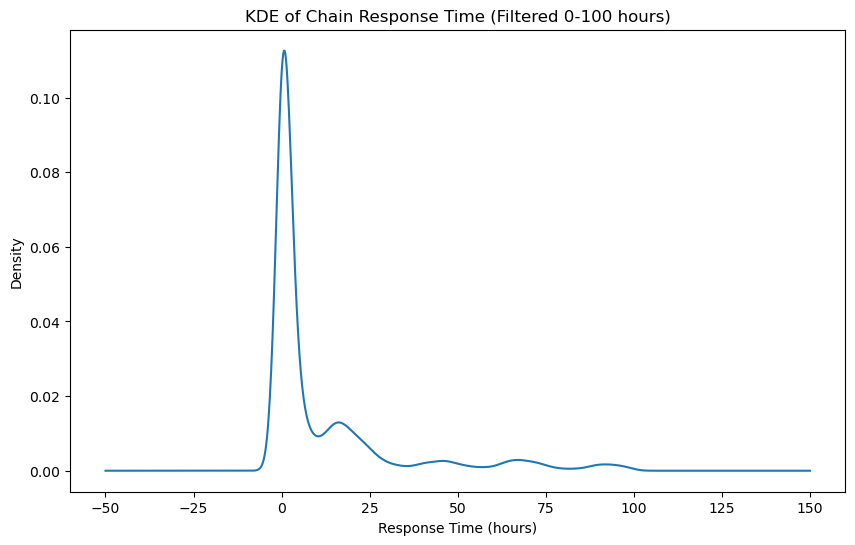

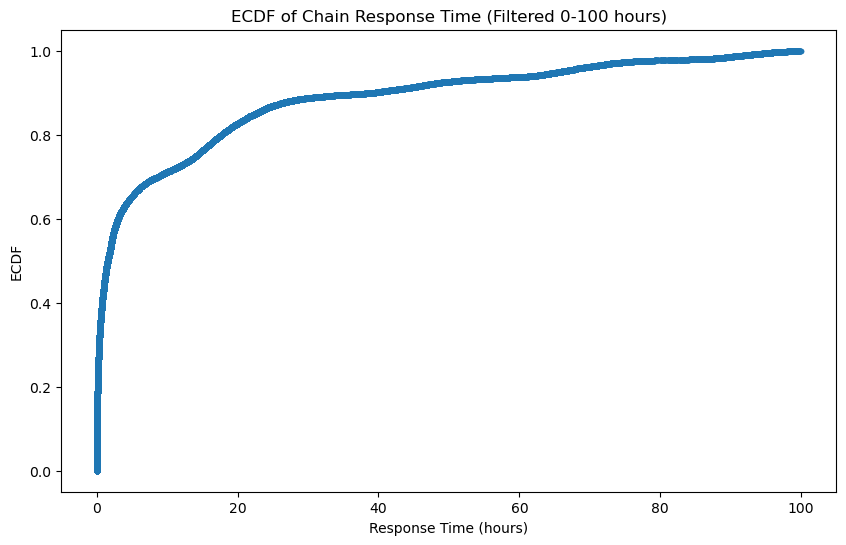

In [121]:
# Filter the response times to a more "typical" range, for example, between 0 and 100 hours
filtered_response = df_chained['response_hours'][(df_chained['response_hours'] > 0) & (df_chained['response_hours'] < 100)]

# Plot the KDE of the filtered data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
filtered_response.plot.kde()
plt.xlabel("Response Time (hours)")
plt.title("KDE of Chain Response Time (Filtered 0-100 hours)")
plt.show()

# You can also plot the ECDF for the filtered data:
import numpy as np

x = np.sort(filtered_response)
y = np.arange(1, len(x) + 1) / len(x)
plt.figure(figsize=(10,6))
plt.plot(x, y, marker=".", linestyle="none")
plt.xlabel("Response Time (hours)")
plt.ylabel("ECDF")
plt.title("ECDF of Chain Response Time (Filtered 0-100 hours)")
plt.show()


In [113]:
import pickle

with open('../data/df_chained.pkl', 'wb') as file:
    pickle.dump(df_chained, file)


## Save the Data 

In [119]:
import pickle

with open('../data/df_original.pkl', 'wb') as file:
    pickle.dump(df, file)


In [1]:
import pickle
with open('../data/df_chained_with_sarcasm.pkl', 'rb') as file:
    df_read = pickle.load(file)


In [3]:
df_read['chained_main_body'][5]

'I=01,ve been asked to provide an updated list on who is authorized to cross=\n=20\ntrade what commodities/products.  As soon as possible, please reply to this=\n=20\nemail with the names of only the authorized =01&cross commodity=018 traders=\n and=20\ntheir respective commodities. (natural gas, crude, heat, gasoline, weather,=\n=20\nprecip, coal, power, forex (list currency), etc..)\n\nThanks,\n\nFrank\n\n\nPS. Traders limited to one commodity do not need to be included on this lis=\nt.'

In [2]:
df_read.tail()

,message_id,stand_date,chained_emails,chained_subject,chained_from,chained_to,chained_date_str,chained_date,chained_main_body,chain_response_time,response_seconds,response_hours,sarcasm
5,<4668224.1075855726338.JavaMail.evans@thyme>,2001-03-06 10:45:00+00:00,"-----Original Message-----From: Hayden, Frank...",Cross Commodity,"Hayden, Frank =20","Presto, Kevin; Zufferli, John; McKay, Jonathan...","Friday, March 02, 2001 7:01 PM",2001-03-03 01:01:00+00:00,"I=01,ve been asked to provide an updated list ...",3 days 09:44:00,294240.0,81.733333,Sarcastic
6,<17085123.1075855727024.JavaMail.evans@thyme>,2001-02-18 19:50:00+00:00,-----Original Message-----> From: Phillip.K.Al...,RE:,Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,jsmith@austintx.com,"Friday, February 16, 2001 8:53 AM",2001-02-16 14:53:00+00:00,From: Phillip.K.Allen@enron.com [mailto:Philli...,2 days 04:57:00,190620.0,52.950000,Non-sarcastic
7,<17085123.1075855727024.JavaMail.evans@thyme>,2001-02-18 19:50:00+00:00,-----Original Message-----> From: Phillip.K.Al...,"Lee,",Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,lodonnell@spbank.com,"Thursday, February 15, 2001 11:34 AM",2001-02-15 17:34:00+00:00,From: Phillip.K.Allen@enron.com [mailto:Philli...,0 days 21:19:00,76740.0,21.316667,Non-sarcastic
8,<33551655.1075855727111.JavaMail.evans@thyme>,2001-02-16 08:52:00+00:00,-----Original Message-----From: Phillip.K.Alle...,"Lee,",Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,lodonnell@spbank.com,"Thursday, February 15, 2001 11:34 AM",2001-02-15 17:34:00+00:00,"Lee,\n\nMy fax number is 713-646-2391. Please...",0 days 15:18:00,55080.0,15.300000,Non-sarcastic
9,<3119834.1075855668771.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prompt attenti...,4 days 22:18:00,425880.0,118.300000,Non-sarcastic


In [23]:
df_read['message'][441]

"Message-ID: <10990186.1075855686348.JavaMail.evans@thyme>\nDate: Tue, 12 Dec 2000 04:03:00 -0800 (PST)\nFrom: phillip.allen@enron.com\nTo: christi.nicolay@enron.com\nSubject: Talking points about California Gas market\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Christi L Nicolay\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\nChristy,\n\n I read these points and they definitely need some touch up.  I don't \nunderstand why we need to give our commentary on  why prices are so high in \nCalifornia.  This subject has already gotten so much press.  \n\nPhillip\n\n\n\n\n\n\n---------------------- Forwarded by Phillip K Allen/HOU/ECT on 12/12/2000 \n12:01 PM ---------------------------\nFrom: Leslie Lawner@ENRON on 12/12/2000 11:56 AM CST\nTo: Christi L Nicolay/HOU/ECT@ECT, Joe Hartsoe/Corp/Enron@ENRON, Rebecca W \nCantrell/HOU/ECT@

## Position df check

In [2]:
import pickle

In [3]:
with open('../data/df_chained_with_positions.pkl', 'rb') as file:
    df_chained = pickle.load(file)


In [8]:
df_chained.head(20)

,message_id,stand_date,chained_emails,chained_subject,chained_from,chained_to,chained_date_str,chained_date,chained_main_body,chain_response_time,response_seconds,response_hours,position
0,<17954197.1075855688641.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prompt attenti...,4 days 22:18:00,425880.0,118.300000,Project Manager for Client Services
1,<2398018.1075855692214.JavaMail.evans@thyme>,2000-02-11 12:31:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,3 days 12:37:00,304620.0,84.616667,Phillip Allen
2,<4627792.1075855692236.JavaMail.evans@thyme>,2000-02-09 10:27:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,1 days 10:33:00,124380.0,34.550000,Credit Desk
3,<12222503.1075855692514.JavaMail.evans@thyme>,2000-01-18 18:06:00+00:00,-----Original Message-----From: pallen@enron.c...,Choosing a style,pallen@enron.com [mailto:pallen@enron.com],designadvice@living.com,"Monday, January 17, 2000 5:20 PM",2000-01-17 23:20:00+00:00,I am planning to build a house in the Texas hi...,0 days 18:46:00,67560.0,18.766667,"{job_title}"")\nelse:\n print("""
4,<30542109.1075855379282.JavaMail.evans@thyme>,2001-04-19 00:51:00+00:00,"-----Original Message-----From: \tAllen, Phill...",Re: Presentation to Trading Track A&A,"Allen, Phillip","Buckley, Karen","Wednesday, April 18, 2001 10:30 AM",2001-04-18 15:30:00+00:00,The topic will the the western natural gas mar...,0 days 09:21:00,33660.0,9.350000,(Note: There is no job title to extract from t...
5,<4668224.1075855726338.JavaMail.evans@thyme>,2001-03-06 10:45:00+00:00,"-----Original Message-----From: Hayden, Frank...",Cross Commodity,"Hayden, Frank =20","Presto, Kevin; Zufferli, John; McKay, Jonathan...","Friday, March 02, 2001 7:01 PM",2001-03-03 01:01:00+00:00,"I=01,ve been asked to provide an updated list ...",3 days 09:44:00,294240.0,81.733333,Traders
6,<17085123.1075855727024.JavaMail.evans@thyme>,2001-02-18 19:50:00+00:00,-----Original Message-----> From: Phillip.K.Al...,RE:,Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,jsmith@austintx.com,"Friday, February 16, 2001 8:53 AM",2001-02-16 14:53:00+00:00,From: Phillip.K.Allen@enron.com [mailto:Philli...,2 days 04:57:00,190620.0,52.950000,HOU/ECT
7,<17085123.1075855727024.JavaMail.evans@thyme>,2001-02-18 19:50:00+00:00,-----Original Message-----> From: Phillip.K.Al...,"Lee,",Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,lodonnell@spbank.com,"Thursday, February 15, 2001 11:34 AM",2001-02-15 17:34:00+00:00,From: Phillip.K.Allen@enron.com [mailto:Philli...,0 days 21:19:00,76740.0,21.316667,pallen@enron.com is not extracted from signatu...
8,<33551655.1075855727111.JavaMail.evans@thyme>,2001-02-16 08:52:00+00:00,-----Original Message-----From: Phillip.K.Alle...,"Lee,",Phillip.K.Allen@enron.com [mailto:Phillip.K.Al...,lodonnell@spbank.com,"Thursday, February 15, 2001 11:34 AM",2001-02-15 17:34:00+00:00,"Lee,\n\nMy fax number is 713-646-2391. Please...",0 days 15:18:00,55080.0,15.300000,Senior Vice President
9,<3119834.1075855668771.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prom

In [4]:
import pickle

In [5]:
## Seniority

In [6]:
with open('../data/df_chained_with_sarcasm.pkl', 'rb') as file:
    df_sarcasm = pickle.load(file)


In [7]:
with open('../data/df_chained_with_positions_llama3_instruct.pkl', 'rb') as file:
    df_seniority = pickle.load(file)


In [10]:
df_sarcasm['sarcasm'].unique()

array(['Non-sarcastic', 'Sarcastic'], dtype=object)

In [11]:
df_seniority['seniority_label'] = df_seniority['seniority'].apply(lambda x: 'Yes' if 'Yes' in str(x) else 'No')

df_seniority.head()


,message_id,stand_date,chained_emails,chained_subject,chained_from,chained_to,chained_date_str,chained_date,chained_main_body,chain_response_time,response_seconds,response_hours,position,seniority,seniority_label
0,<17954197.1075855688641.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prompt attenti...,4 days 22:18:00,425880.0,118.300000,Project Manager,No,No
1,<2398018.1075855692214.JavaMail.evans@thyme>,2000-02-11 12:31:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,3 days 12:37:00,304620.0,84.616667,Thanks,No,No
2,<4627792.1075855692236.JavaMail.evans@thyme>,2000-02-09 10:27:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,1 days 10:33:00,124380.0,34.550000,"Thanks, Phillip Allen",No,No
3,<12222503.1075855692514.JavaMail.evans@thyme>,2000-01-18 18:06:00+00:00,-----Original Message-----From: pallen@enron.c...,Choosing a style,pallen@enron.com [mailto:pallen@enron.com],designadvice@living.com,"Monday, January 17, 2000 5:20 PM",2000-01-17 23:20:00+00:00,I am planning to build a house in the Texas hi...,0 days 18:46:00,67560.0,18.766667,None,N,No
4,<30542109.1075855379282.JavaMail.evans@thyme>,2001-04-19 00:51:00+00:00,"-----Original Message-----From: \tAllen, Phill...",Re: Presentation to Trading Track A&A,"Allen, Phillip","Buckley, Karen","Wednesday, April 18, 2001 10:30 AM",2001-04-18 15:30:00+00:00,The topic will the the western natural gas mar...,0 days 09:21:00,33660.0,9.350000,Director,No,No


In [13]:
df_seniority['seniority_label'].unique()

array(['No', 'Yes'], dtype=object)

In [14]:
df_sarcasm['seniority'] = df_seniority['seniority_label']

In [15]:
df_sarcasm.head()

,message_id,stand_date,chained_emails,chained_subject,chained_from,chained_to,chained_date_str,chained_date,chained_main_body,chain_response_time,response_seconds,response_hours,sarcasm,seniority
0,<17954197.1075855688641.JavaMail.evans@thyme>,2000-09-05 13:51:00+00:00,-----Original Message-----From: Christi Smith ...,Receipt of Team Selection Form - Executive Imp...,Christi Smith [mailto:christi.smith@lrinet.com],'Phillip.K.Allen@enron.com',"Thursday, August 31, 2000 10:33 AM",2000-08-31 15:33:00+00:00,Hi Phillip. We appreciate your prompt attenti...,4 days 22:18:00,425880.0,118.300000,Non-sarcastic,No
1,<2398018.1075855692214.JavaMail.evans@thyme>,2000-02-11 12:31:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,3 days 12:37:00,304620.0,84.616667,Non-sarcastic,No
2,<4627792.1075855692236.JavaMail.evans@thyme>,2000-02-09 10:27:00+00:00,-----Original Message-----> From: Phillip_K_Al...,Re: W basis quotes,Phillip_K_Allen@enron.com [mailto:Phillip_K_Al...,george.rahal@acnpower.com,"Monday, February 07, 2000 5:54 PM",2000-02-07 23:54:00+00:00,From: Phillip_K_Allen@enron.com [mailto:Philli...,1 days 10:33:00,124380.0,34.550000,Non-sarcastic,No
3,<12222503.1075855692514.JavaMail.evans@thyme>,2000-01-18 18:06:00+00:00,-----Original Message-----From: pallen@enron.c...,Choosing a style,pallen@enron.com [mailto:pallen@enron.com],designadvice@living.com,"Monday, January 17, 2000 5:20 PM",2000-01-17 23:20:00+00:00,I am planning to build a house in the Texas hi...,0 days 18:46:00,67560.0,18.766667,Non-sarcastic,No
4,<30542109.1075855379282.JavaMail.evans@thyme>,2001-04-19 00:51:00+00:00,"-----Original Message-----From: \tAllen, Phill...",Re: Presentation to Trading Track A&A,"Allen, Phillip","Buckley, Karen","Wednesday, April 18, 2001 10:30 AM",2001-04-18 15:30:00+00:00,The topic will the the western natural gas mar...,0 days 09:21:00,33660.0,9.350000,Non-sarcastic,No


In [16]:
with open('../data/df_sarcasm_seniority_v2.pkl', 'wb') as file:
    pickle.dump(df_sarcasm, file)